# Sailors

### Requirements

In [32]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Display the BaseAgent class documentation
#help(BaseAgent)

## I. Matelot 1

### Defining Agent

In [63]:
def live_plot(data_dict, x_key=None, limit=None, window=None,
            data_dict2=None, x_key2=None, limit2=None, window2=None,
            figsize=(7,5), title='', title2='', sailor=None):
    
    clear_output(wait=True)

    if data_dict2 is not None and x_key2 is not None and sailor is not None:
        fig, axs = plt.subplots(3, 2, figsize=figsize)
    elif data_dict2 is not None and x_key2 is not None and sailor is None:
        fig, axs = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, axs = plt.subplots(1, 1, figsize=figsize)
        axs = [axs]  # Pour uniformiser le traitement

    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        if label == x_key or len(data) == 0:
            continue
        x = data_dict[x_key] if x_key is not None else np.arange(len(data))
        axs[0, 0].plot(x, data, label=label, linewidth=1)

    axs[0, 0].set_title(title)
    axs[0, 0].grid(alpha=.2, which='both')
    axs[0, 0].set_xlabel('epoch' if x_key is None else x_key)
    axs[0, 0].legend(loc='center left')
    if limit is not None:
        axs[0, 0].set_ylim(0, limit)
    if window is not None:
        axs[0, 0].set_xlim(0, window)

    if data_dict2 is not None and x_key2 is not None:
        for label, data in data_dict2.items():
            if label == x_key2 or len(data) == 0:
                continue
            x = data_dict2[x_key2] if x_key2 is not None else np.arange(len(data))
            axs[0,1].plot(x, data, label=label, linewidth=1)
        axs[0,1].set_title(title2)
        axs[0,1].grid(alpha=.5, which='both')
        axs[0,1].set_xlabel('epoch' if x_key2 is None else x_key2)
        axs[0,1].legend(loc='center left')

        if limit is not None:
            axs[0,1].set_ylim(0, limit2)

        if window2 is not None:
            axs[0,1].set_xlim(0, window2)

    if sailor is not None:
        l_v_ang = []
        l_v_mag = []
        l_dot = []
        l_actions = []

        for state in sailor.q_table.keys():
            for tup in sailor.q_speed[state]:
                v_ang, v_mag = tup
                l_v_ang.append(v_ang)
                l_v_mag.append(v_mag)
            
            if state in sailor.q_dot.keys():
                for dot in sailor.q_dot[state]:
                    l_dot.append(dot)

            if state in sailor.q_visit.keys():
                if sailor.q_visit[state] > 1:
                    actions = np.argmax(sailor.q_table[state])
                    l_actions.append(actions)

        # Histogramme pour l_v_ang
        axs[1,0].hist(l_v_ang, bins=max(l_v_ang)+1, color='skyblue', edgecolor='black')
        axs[1,0].set_title('Histogramme de l_v_ang')
        axs[1,0].set_xlabel('Valeurs de l_v_ang')
        axs[1,0].set_ylabel('Fréquence')

        # Histogramme pour l_v_bin
        axs[1,1].hist(l_v_mag, bins=10, color='lightgreen', edgecolor='black')
        axs[1,1].set_title('Histogramme de l_v_mag')
        axs[1,1].set_xlabel('Valeurs de l_v_mag')
        axs[1,1].set_ylabel('Fréquence')

        # Histogramme pour l_w_ang
        axs[2,0].hist(l_dot, bins=10, color='salmon', edgecolor='black')
        axs[2,0].set_title('Histogramme de Dot')
        axs[2,0].set_xlabel('Valeurs de Dot')
        axs[2,0].set_ylabel('Fréquence')

        # Histogramme pour actions
        axs[2,1].hist(l_actions, bins=8, color='gold', edgecolor='black')
        axs[2,1].set_title('Histogramme de actions')
        axs[2,1].set_xlabel('Valeurs de actions')
        axs[2,1].set_ylabel('Fréquence')

        # Ajuster l'espacement entre les sous-graphiques
        plt.tight_layout()
        

    plt.show()

In [115]:
class Matelot_2(BaseAgent):
    """A minimal valid agent that meets all interface requirements."""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        super().__init__()
        self.np_random = np.random.default_rng()

        self.learning_rate = learning_rate
        self.adapt = 0.01
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate

        self.position_bins = 32     # Discretize the grid into 32 x 32
        self.veloc_angle_bins = 8     # Discretize velocity into 4 bins
        self.win_angle_bins = 8        # Discretize wind directions into 8 bins

        self.q_table = {}
        self.size_state = 0
        
        self.q_visit = {}
        self.q_speed = {}
        self.ite_learned = 0
        self.training_session = 0
        self.restart_training = False

        self.hist_pos = []
        self.hist_veloc = []
        self.hist_wind = []
        self.hist_actions = []
        self.hist_explore = []
        self.hist_wind_xy = []
        self.q_dot = {}

    def discretize_state(self, observation):
        """Convert continuous observation to discrete state for Q-table lookup."""
        # Extract position, velocity and wind from observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discretize position (assume 32x32 grid)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        

        # Discretize velocity direction (ignoring magnitude for simplicity)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # If velocity is very small, consider it as a separate bin
            v_ang = 0
            v_mag = 0
        else:
            v_direction = np.arctan2(vy, vx)  # Range: [-pi, pi]
            v_ang = int(((v_direction + np.pi) / (2 * np.pi) * (self.veloc_angle_bins-1)) + 1) % self.veloc_angle_bins
            v_mag = int(5*v_magnitude)
        
        # Discretize wind direction
        def wind_transf(wx, wy):
            wind_direction = np.arctan2(wy, wx)  # Range: [-pi, pi]
            wind_ang = int(((wind_direction + np.pi) / (2 * np.pi) * self.win_angle_bins)) % self.win_angle_bins
            wind_mag = int(4*np.sqrt(wx**2 + wy**2))
            return wind_ang, wind_mag

        wind_ang, wind_mag = wind_transf(wx,wy)

        t1 = (x_bin, y_bin, v_ang, wind_ang)

        t_pos = []
        t_neg = []
        t2 = []
        bloc = []
        h_bloc = 8
        w_bloc = 6
        i = 0
        while i < grid_size:
            bloc.clear()
            t_pos.clear()
            t_neg.clear()

            for x in range(h_bloc):
                line = (i+x) * (2*32)
                for y in range(1,w_bloc+1):
                    wx_neg, wy_neg = observation[6 + line + 32 - 2*y], observation[6 + line + 33 - 2*y]
                    wa_neg,wx_neg = wind_transf(wx_neg,wy_neg)
                    t_neg.append(wa_neg)

                    wx_pos, wy_pos = observation[6 + line + 30 + 2*y], observation[6 + line + 31 + 2*y]
                    wa_pos,wx_pos = wind_transf(wx_pos,wy_pos)
                    t_pos.append(wa_pos)

            i += h_bloc
            med_pos = int(np.median(t_pos))
            med_neg = int(np.median(t_neg))

            t2.extend((med_pos, med_neg))

        t2 = tuple(t2)
        

        self.hist_pos.append((x_bin, y_bin))
        self.hist_veloc.append((v_ang, v_mag))
        self.hist_wind.append((wind_ang, wind_mag))

        if t1 + t2 not in self.q_speed.keys():
            self.q_speed[t1 + t2] = [(v_ang, v_mag)]
        else:
            self.q_speed[t1 + t2].append((v_ang, v_mag))


        if len(self.hist_wind_xy) > 0:
            wwx, wwy = self.hist_wind_xy[-1]
            a = np.array([vx, vy, 0])
            b = np.array([wwx, wwy, 0])

            z = np.dot(a, b)
            norm_a = np.linalg.norm(a)
            norm_b = np.linalg.norm(b)

            if norm_a !=0 and norm_b != 0:
                dot = (z / (norm_a * norm_b))

                if t1 + t2 not in self.q_dot.keys():
                    self.q_dot[t1 + t2] = [dot]
                else:
                    self.q_dot[t1 + t2].append(dot)

        self.hist_wind_xy.append((wx, wy))
        # Return discrete state tuple
        return t1 + t2
    
        
    
    def act(self, observation: np.ndarray) -> int:
        """Choose an action using epsilon-greedy policy."""
        # Discretize the state
        state = self.discretize_state(observation)
        self.size_state = len(state)

        if state in self.q_visit.keys():
            self.q_visit[state] += 1
        else:
            self.q_visit[state] = 1
        
        adapt_exploration = self.exploration_rate * max(.05,(1 - self.adapt*(self.q_visit[state])))

        # Epsilon-greedy action selection
        if self.np_random.random() < adapt_exploration:
            twist = np.random.rand()
            if twist < adapt_exploration:
            # Explore: choose a random action
                i = self.np_random.integers(0,2)
                if i == 0:
                    j = 7
                else: 
                    j = 1
            else:
                j = self.np_random.integers(0,9)
            self.hist_actions.append(j)
            self.hist_explore.append(1.)
            action = int(j)
        else:
            # Exploit: choose the best action according to Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(9)
                self.hist_actions.append(np.argmax(self.q_table[state]))
            # Return action with highest Q-value
            self.hist_explore.append(0.)
            action = np.argmax(self.q_table[state])
        
        return action
        

    def learn(self, state, action, reward, next_state):
        """Update Q-table based on observed transition."""
        self.ite_learned += 1

        # Initialize Q-values if states not in table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
            
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)

        # use of adaptive learning_rate
        adapt_learning_rate = self.learning_rate / (1 + self.adapt*self.q_visit[state])

        # use of exploration bonus
        exploration_bonus = 1 / (1 + np.sqrt(self.q_visit[state]))
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action] + exploration_bonus # modified
        self.q_table[state][action] += adapt_learning_rate * td_error   # modified
    
    def reset(self) -> None:
        """Reset the agent."""
        self.q_table.clear()
        self.ite_learned = 0
        self.training_session = 0
    
    def set_hist(self) -> None:
        """Reset only history variables"""
        self.hist_pos.clear()
        self.hist_veloc.clear()
        self.hist_wind.clear()
        self.hist_explore.clear()
        self.hist_actions.clear()
        self.hist_wind_xy.clear()

    def seed(self, seed= None) -> dict:
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)

    def test(self, num_test, max_steps, seed=None):
        """Simple testing method during training to show improvements of results without exploration"""
        # Turn off exploration for evaluation
        exploration_rate = self.exploration_rate
        self.exploration_rate = 0

        print("------ BEGINNING TEST -------------------------------                                ")
        print(f"exploration rate set to : {self.exploration_rate}")

        # Create test environment
        dico_env = {}
        dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
        dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
        dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))

        i = np.random.randint(1, 4)
        test_env = dico_env[i]

        print(f"Testing the trained agent on {num_test} new episodes...")
        # Testing loop
        
        results_steps = []
        results_rew = []
        results_avg_speed = []

        for episode in range(num_test):
            if seed is None:
                a_seed = 100000+episode
            else:
                a_seed = seed[episode]
            # Reset environment
            observation, info = test_env.reset(seed=a_seed)  # Different seeds from training
            self.set_hist()
            
            total_reward = 0
            
            for step in range(max_steps):
                # Select action using learned policy
                action = self.act(observation)
                observation, reward, done, truncated, info = test_env.step(action)
                
                total_reward += reward*np.power(self.discount_factor, step)
                
                # Break if episode is done
                if done or truncated:
                    results_steps.append(step)
                    results_rew.append(total_reward)
                    results_avg_speed.append(np.mean(self.hist_veloc[:1]))
                    break
            
            if not(done):
                results_steps.append(step)
                results_rew.append(0)
        
        self.exploration_rate = exploration_rate

        med_s = np.mean(results_steps)
        q10_s = min(results_steps)
        q90_s = max(results_steps)

        med_r = np.mean(results_rew)
        q10_r = min(results_rew)
        q90_r = max(results_rew)

        med_a = np.median(results_avg_speed)
        q10_a = np.quantile(results_avg_speed, 0.1)
        q90_a = np.quantile(results_avg_speed, 0.9)

        print(f"exploration rate re-set to : {self.exploration_rate}")
            
        return med_s, q10_s, q90_s, med_r, q10_r, q90_r

    def show_visited_state(self, interpol = "nearest", show = True):
        matrice = np.zeros((self.position_bins, self.position_bins), dtype=int)

        for key in self.q_visit.keys():
            x, y, v_ang, v_mag, w_ang, w_mag = key
            matrice[y][x] += self.q_visit[key] / self.training_session

        if show == True:
            matrice = np.log(matrice + 1)
            plt.figure(figsize=(6, 6))
            plt.imshow(matrice, cmap='Blues', interpolation=interpol)
            plt.colorbar()
            plt.gca().invert_yaxis()  # Inversion de l'axe Y
            plt.show()
        else:
            return matrice

        

### Training

In [116]:
sailor = Matelot_2(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.3)

np.random.seed(42)
sailor.seed(42)

sailor.restart_training = False

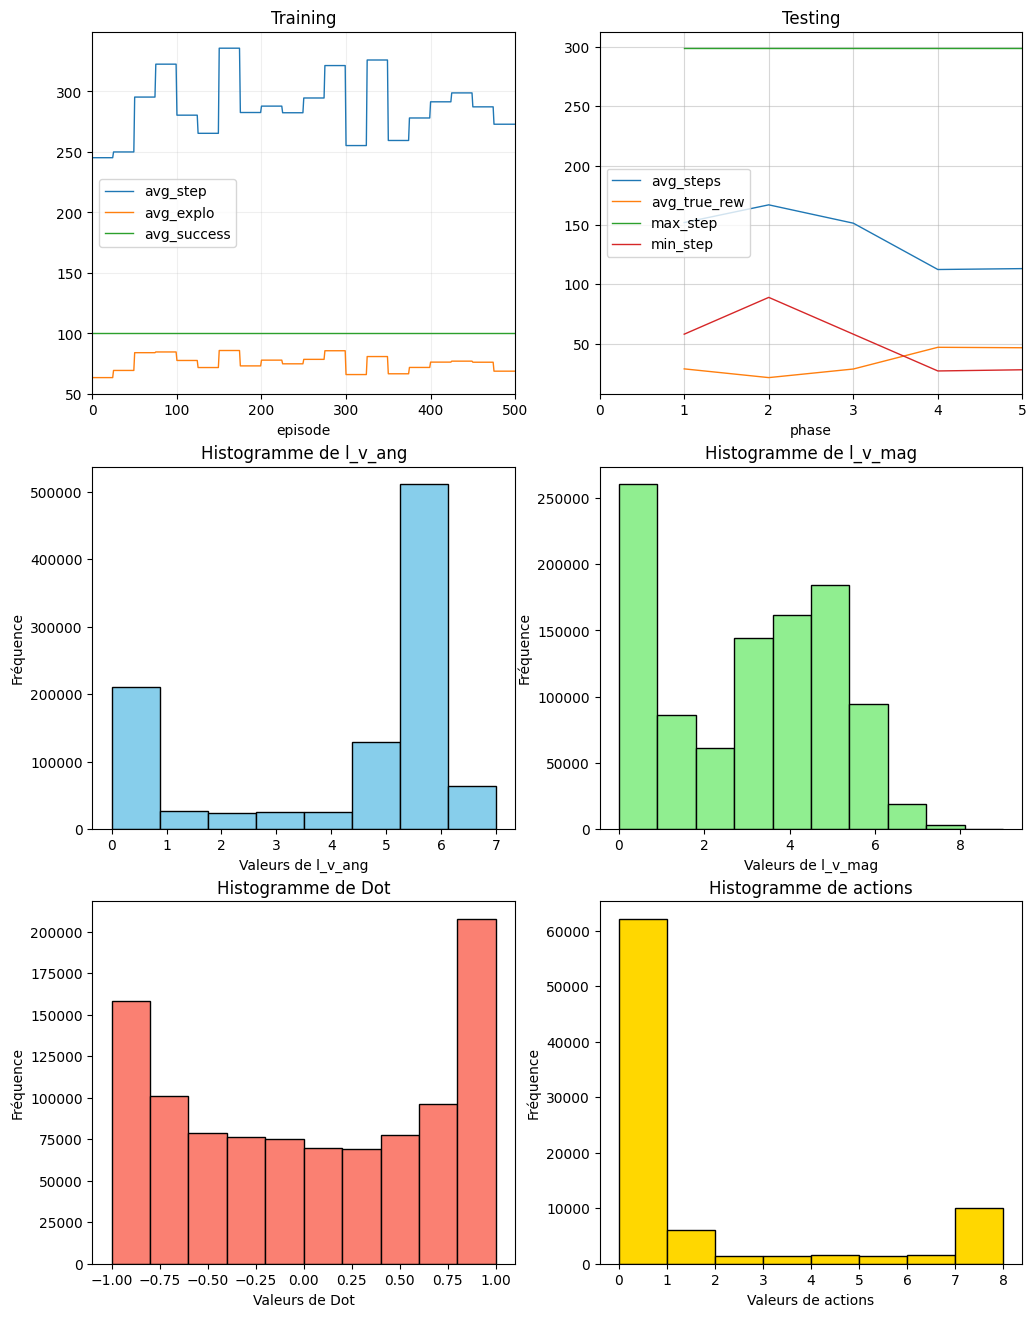

<Figure size 1200x1600 with 0 Axes>


Training completed in 1160.0 seconds!
Success rate: 1.0%
Average reward: 94.00
Average steps: 286.6
Q-table size: 187465 states


In [146]:
import time
%matplotlib inline

## SETTING SAILOR PARAMETERS
sailor.exploration_rate = 0.3
sailor.restart_training = False


## HYPERPARAMATERS FOR TRAINING PHASE
num_episodes = 500  # Small number for debugging
max_steps = 1000    

batch_train = 25
batch_test = 100



if sailor.restart_training == True:
# This line reinitializes q table
    sailor.reset()
    sailor.restart_training = False


# Create environment with a simple initial windfield
dico_env = {}
dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))
    
# Progress tracking
train_hist = {"episode": [], "rewards": [], "steps": [], "success": [], "true_reward": [], "q_table": [],"avg_step" : [], "exploration" : [], "avg_explo": [], "avg_success": []}
test_hist = {"phase": [], "avg_steps": [], "avg_true_rew": [], "max_step": [], "min_step": []}
phase = 0

# Training loop
print(f"Starting full training with {num_episodes} episodes...")

start_time = time.time()

for episode in range(num_episodes):

    # CHOSE ENVIRONEMENT FOR EPISODE
    i = np.random.randint(1, 4)
    env = dico_env[i]
    # Reset environment and get initial state
    sailor.set_hist()
    sailor.training_session += 1

    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = sailor.discretize_state(observation)
    # SET REWARD TO 0
    total_reward = 0

    if episode==0:
        print(f"Length of state : {len(state)}")
        print(f"training sessions : {sailor.training_session}")
    
    for step in range(max_steps):
        # Select action and take step
        action = sailor.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = sailor.discretize_state(next_observation)
        
        # Update Q-table
        sailor.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    train_hist["episode"].append(episode)
    train_hist["rewards"].append(total_reward)
    train_hist["steps"].append(step + 1)
    train_hist["success"].append(done)
    train_hist["true_reward"].append(np.power(sailor.discount_factor,step)*total_reward)
    train_hist["q_table"].append(len(sailor.q_table))




    train_hist["exploration"].append(np.sum(sailor.hist_explore))


    if (episode + 1) % batch_train == 0:
        avg = np.mean(train_hist["steps"][-batch_train:])
        avg_l = np.ones((batch_train))*avg
        train_hist["avg_step"].extend(avg_l)

        avg = np.mean(train_hist["exploration"][-batch_train:])
        avg_l = np.ones((batch_train))*avg
        train_hist["avg_explo"].extend(avg_l)

        avg = np.mean(train_hist["success"][-batch_train:])
        avg_l = np.ones((batch_train))*avg*100
        train_hist["avg_success"].extend(avg_l)


        tempo_dico = {key: train_hist[key] for key in ["episode", "avg_step", "avg_explo", "avg_success"] if key in train_hist}
        live_plot(data_dict=tempo_dico, x_key="episode",title="Training", window=num_episodes,
                  data_dict2=test_hist, x_key2="phase", title2="Testing", window2=num_episodes/batch_test, figsize=(12,16), sailor=sailor)
        
    if (episode + 1) % batch_test == 0:
        phase += 1
        a_s, mi_s, ma_s, a_r, mi_r, ma_r = sailor.test(num_test=100, max_steps=300)
        test_hist["avg_steps"].append(a_s)
        test_hist["avg_true_rew"].append(a_r)
        test_hist["max_step"].append(ma_s)
        test_hist["min_step"].append(mi_s)
        test_hist["phase"].append(phase)
        tempo_dico = {key: train_hist[key] for key in ["episode", "avg_step", "avg_explo", "avg_success"] if key in train_hist}
        live_plot(data_dict=tempo_dico, x_key="episode",title="Training", window=num_episodes,
                  data_dict2=test_hist, x_key2="phase", title2="Testing", window2=num_episodes/batch_test, figsize=(12,16), sailor=sailor)

        
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {np.sum((train_hist['success']))/num_episodes:.1f}%")
print(f"Average reward: {np.mean(train_hist['rewards']):.2f}")
print(f"Average steps: {np.mean(train_hist['steps']):.1f}")
print(f"Q-table size: {len(sailor.q_table)} states")

In [118]:
def show_visited_state(sailor, interpol = "nearest", show = True):
    matrice = np.zeros((sailor.position_bins, sailor.position_bins), dtype=int)

    for key in sailor.q_visit.keys():
        x = key[0] 
        y = key[1]
        v_ang = key[2]
        w_ang= key[3]
        matrice[y][x] += sailor.q_visit[key]

    if show == True:
        matrice = np.log(matrice + 1)
        plt.figure(figsize=(6, 6))
        plt.imshow(matrice, cmap='Blues', interpolation=interpol)
        plt.colorbar()
        plt.gca().invert_yaxis()  # Inversion de l'axe Y
        plt.show()
    else:
        return matrice

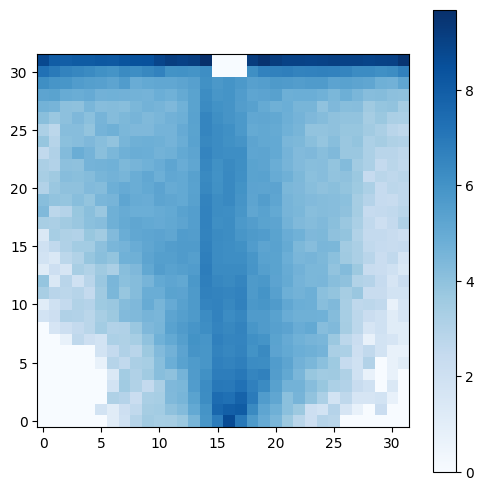

In [127]:
show_visited_state(sailor)

In [136]:
def show_speed(sailor, interpol = "nearest", show = True):
    matrice = [[[] for _ in range(32)] for _ in range(32)]

    for key in sailor.q_speed.keys():
        x = key[0] 
        y = key[1]
        v_ang = key[2]
        w_ang = key[3]
        matrice[y][x].extend(sailor.q_speed[key])

    for x in range(32):
        for y in range(32):
            if matrice[x][y] == []:
                matrice[x][y] = [0]

    if show == True:
        matrice = np.mean(matrice)
        plt.figure(figsize=(6, 6))
        plt.imshow(matrice, cmap='Blues', interpolation=interpol)
        plt.colorbar()
        plt.gca().invert_yaxis()  # Inversion de l'axe Y
        plt.show()
    else:
        return matrice

### Training Performance

In [145]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
%matplotlib notebook

n = np.random.randint(0, 100000)
sailor.test(num_test=1, max_steps=500, seed=[n])

coordinates = sailor.hist_pos
x_data = []
y_data = []

for x, y in coordinates:
    x_data.append(x)
    y_data.append(y)

# Initialisation de la figure et des axes
fig, ax = plt.subplots()
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
line, = ax.plot([], [], 'b-', lw=2)  # 'b-' signifie une ligne bleue
title = ax.set_title("Steps")


# Initialisation de la ligne
def init():
    line.set_data([], [])
    return line,

# Fonction d'animation
def animate(i):
    if i > 10:
        x = x_data[i-10:i]
        y = y_data[i-10:i]
    else:
        x = x_data[:i]
        y = y_data[:i]
    line.set_data(x, y)
    title.set_text(f"Steps - {i}")
    return line,

# Création de l'animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(coordinates), interval=50, blit=True)

# Affichage de l'animation dans un notebook Jupyter
HTML(ani.to_jshtml())


------ BEGINNING TEST -------------------------------                                
exploration rate set to : 0
Testing the trained agent on 1 new episodes...
exploration rate re-set to : 0.4


<IPython.core.display.Javascript object>

In [55]:
sailor.hist_explore

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

### Saving Agent

In [147]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=sailor,
    output_path="agents/matelot_2.py",
    agent_class_name="Matelot_2"
)

Agent saved to agents/matelot_2.py
The file contains 187465 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb
